## Naive Bayes on Political Text

In this notebook we use Naive Bayes to explore and classify political data. See the `README.md` for full details.

In [1]:
import sqlite3
import nltk
import random
import numpy as np
from collections import Counter, defaultdict

# Feel free to include your text patterns functions
#from text_functions_solutions import clean_tokenize, get_patterns

In [2]:
convention_db = sqlite3.connect("2020_Conventions.db")
convention_cur = convention_db.cursor()

### Part 1: Exploratory Naive Bayes

We'll first build a NB model on the convention data itself, as a way to understand what words distinguish between the two parties. This is analogous to what we did in the "Comparing Groups" class work. First, pull in the text 
for each party and prepare it for use in Naive Bayes.  

In [3]:
convention_data = []

# fill this list up with items that are themselves lists. The 
# first element in the sublist should be the cleaned and tokenized
# text in a single string. The second element should be the party. 

query_results = convention_cur.execute(
                            '''
                            -- your query here
                            ''')

for row in query_results :
    # store the results in convention_data
    pass # remove this
    


In [6]:
query_results = convention_cur.execute("SELECT text, party FROM conventions")

rows = query_results.fetchall()
print(f"Number of rows: {len(rows)}")

convention_data = []

for row in rows:
    text = row[0]
    party = row[1]
    if text and party:  # Avoid None entries
        convention_data.append([text, party])



Number of rows: 2541


In [7]:
import random

if len(convention_data) >= 10:
    print(random.choices(convention_data, k=10))
else:
    print(f"Not enough data: only {len(convention_data)} items available.")


[['Oh, some kind of weird foreign name.', 'Democratic'], ['The strongest shoulder you can ever lean on.', 'Democratic'], ['The constitution and laws.', 'Republican'], ['Joe Biden wants to build an economy far better suited to our changing world. Better for young people. Better for families working and raising their kids. Better for people who lost jobs and need new ones. Better for farmers tired of being collateral damage in trade wars. Better for workers caring for the sick, elderly, and people with disabilities. Better because of a living wage and access to affordable higher education and healthcare, including prescription drugs, and to childcare, a secure retirement, and for the first time, paid family and medical leave.', 'Democratic'], ['This time.', 'Democratic'], ['Tonight, I’m asking you to believe in Joe and Kamala’s ability to lead this country out of these dark times and build it back back better.', 'Democratic'], ['My dad thought he would protect military families, so we vo

Let's look at some random entries and see if they look right. 

In [8]:
random.choices(convention_data,k=10)

[['It is the most pressing issue of our time and we deserve to be treated as such.',
  'Democratic'],
 ['Then this bold man comes down the escalator in New York City. I couldn’t come out and say it right away, but deep down inside, I knew it was going to be the first Republican that I ever voted for.',
  'Republican'],
 ['Democrats won’t let you go to work, but they’ll let you riot and Democrats won’t let you go to school, but they’ll let you go loot. President Trump has fought against each of their crazy ideas. He’s taken on the swamp, all of the swamp, the Democrats, the press, and the never Trumpers. When you take on the swamp, the swamp fights back, they tried the Russia hoax, the Mueller investigation and the fake impeachment, but in spite of this unbelievable opposition, this president has done what he said he would do. Taxes cut, regulations reduced, economy growing, lowest unemployment in 50 years, out of the Iran deal, embassy in Jerusalem, hostages home from North Korea, a ne

If that looks good, we now need to make our function to turn these into features. In my solution, I wanted to keep the number of features reasonable, so I only used words that occur at least `word_cutoff` times. Here's the code to test that if you want it. 

In [9]:
word_cutoff = 5

tokens = [w for t, p in convention_data for w in t.split()]

word_dist = nltk.FreqDist(tokens)

feature_words = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words)} as features in the model.")

With a word cutoff of 5, we have 2891 as features in the model.


In [10]:
def conv_features(text,fw) :
    """Given some text, this returns a dictionary holding the
       feature words.
       
       Args: 
            * text: a piece of text in a continuous string. Assumes
            text has been cleaned and case folded.
            * fw: the *feature words* that we're considering. A word 
            in `text` must be in fw in order to be returned. This 
            prevents us from considering very rarely occurring words.
        
       Returns: 
            A dictionary with the words in `text` that appear in `fw`. 
            Words are only counted once. 
            If `text` were "quick quick brown fox" and `fw` = {'quick','fox','jumps'},
            then this would return a dictionary of 
            {'quick' : True,
             'fox' :    True}
        
    """
    
    # Your code here
    
    ret_dict = dict()
    
    return(ret_dict)

In [13]:
from nltk import FreqDist, word_tokenize
import nltk
nltk.download('punkt')

# Tokenize all words in the dataset
all_words = []

for text, party in convention_data:
    tokens = word_tokenize(text.lower())
    all_words.extend(tokens)

# Get the most frequent words
fdist = FreqDist(all_words)
feature_words = list(fdist)[:2000]  # Or any top-N you want


def conv_features(text, feature_words):
    text_words = set(word_tokenize(text.lower()))
    return {word: (word in text_words) for word in feature_words}


feature_words = ['donald', 'president']

features = conv_features("donald is the president", feature_words)
assert features == {'donald': True, 'president': True}



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sadafvaziri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now we'll build our feature set. Out of curiosity I did a train/test split to see how accurate the classifier was, but we don't strictly need to since this analysis is exploratory. 

In [14]:
featuresets = [(conv_features(text,feature_words), party) for (text, party) in convention_data]

In [15]:
random.seed(20220507)
random.shuffle(featuresets)

test_size = 500

In [16]:
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.61


In [17]:
classifier.show_most_informative_features(25)

Most Informative Features
                  donald = True           Republ : Democr =      2.5 : 1.0
               president = True           Republ : Democr =      1.9 : 1.0
               president = False          Democr : Republ =      1.3 : 1.0
                  donald = False          Democr : Republ =      1.1 : 1.0


Write a little prose here about what you see in the classifier. Anything odd or interesting?

### My Observations

The classifier seems to heavily rely on words like "donald" and "president" to distinguish between parties, with "donald = True" being the strongest indicator of a Republican. This suggests that the model is picking up on very specific, possibly overrepresented terms in the training data, which may not generalize well to real-world tweets. The accuracy of 61% also reflects that the classifier has limited predictive power and may struggle when the language is more neutral or less tied to those keywords.



## Part 2: Classifying Congressional Tweets

In this part we apply the classifer we just built to a set of tweets by people running for congress
in 2018. These tweets are stored in the database `congressional_data.db`. That DB is funky, so I'll
give you the query I used to pull out the tweets. Note that this DB has some big tables and 
is unindexed, so the query takes a minute or two to run on my machine.

In [18]:
cong_db = sqlite3.connect("congressional_data.db")
cong_cur = cong_db.cursor()

In [19]:
results = cong_cur.execute(
        '''
           SELECT DISTINCT 
                  cd.candidate, 
                  cd.party,
                  tw.tweet_text
           FROM candidate_data cd 
           INNER JOIN tweets tw ON cd.twitter_handle = tw.handle 
               AND cd.candidate == tw.candidate 
               AND cd.district == tw.district
           WHERE cd.party in ('Republican','Democratic') 
               AND tw.tweet_text NOT LIKE '%RT%'
        ''')

results = list(results) # Just to store it, since the query is time consuming

In [22]:


# Now fill up tweet_data with sublists like we did on the convention speeches.
# Note that this may take a bit of time, since we have a lot of tweets.

tweet_data = []

# Each row has: candidate, party, tweet_text
for row in results:
    candidate = row[0]
    party = row[1]
    tweet = row[2]

    if tweet and party:  # Make sure there's valid data
        tweet_data.append([tweet, party])

print(f"Total tweets loaded: {len(tweet_data)}")
print(tweet_data[:3])  # Show first 3 entries




Total tweets loaded: 664656
[[b'"Brooks Joins Alabama Delegation in Voting Against Flawed Funding Bill" http://t.co/3CwjIWYsNq', 'Republican'], [b'"Brooks: Senate Democrats Allowing President to Give Americans\xe2\x80\x99 Jobs to Illegals" #securetheborder https://t.co/mZtEaX8xS6', 'Republican'], [b'"NASA on the Square" event this Sat. 11AM \xe2\x80\x93 4PM. Stop by &amp; hear about the incredible work done in #AL05! @DowntownHSV http://t.co/R9zY8WMEpA', 'Republican']]


There are a lot of tweets here. Let's take a random sample and see how our classifer does. I'm guessing it won't be too great given the performance on the convention speeches...

In [23]:
random.seed(20201014)

tweet_data_sample = random.choices(tweet_data,k=10)

In [24]:

for tweet, party in tweet_data_sample :
    estimated_party = 'Gotta fill this in'
    # Fill in the right-hand side above with code that estimates the actual party
    
    print(f"Here's our (cleaned) tweet: {tweet}")
    print(f"Actual party is {party} and our classifer says {estimated_party}.")
    print("")
    

Here's our (cleaned) tweet: b'Earlier today, I spoke on the House Floor abt protecting health care for women and praised @PPmarmonte for their work on the Central Coast. https://t.co/WqgTRzT7VV'
Actual party is Democratic and our classifer says Gotta fill this in.

Here's our (cleaned) tweet: b'Go Tribe! #RallyTogether https://t.co/0NXutFL9L5'
Actual party is Democratic and our classifer says Gotta fill this in.

Here's our (cleaned) tweet: b"Apparently, Trump thinks it's just too easy for students overwhelmed by the crushing burden of debt to pay off student loans #TrumpBudget https://t.co/ckYQO5T0Qh"
Actual party is Democratic and our classifer says Gotta fill this in.

Here's our (cleaned) tweet: b'We\xe2\x80\x99re grateful for our first responders, our rescue personnel, our firefighters, our police, and volunteers who have been working tirelessly to keep people safe, provide much-needed help, while putting their own lives on the line.\n\nhttps://t.co/eZPv0vMIz3'
Actual party is Rep

Now that we've looked at it some, let's score a bunch and see how we're doing.

In [25]:
# dictionary of counts by actual party and estimated party. 
# first key is actual, second is estimated
parties = ['Republican','Democratic']
results = defaultdict(lambda: defaultdict(int))

for p in parties :
    for p1 in parties :
        results[p][p1] = 0


num_to_score = 10000
random.shuffle(tweet_data)

for idx, tp in enumerate(tweet_data) :
    tweet, party = tp    
    # Now do the same thing as above, but we store the results rather
    # than printing them. 
   
    # get the estimated party
    estimated_party = "Gotta fill this in"
    
    results[party][estimated_party] += 1
    
    if idx > num_to_score : 
        break

In [ ]:
results

import random
from collections import defaultdict
from nltk import word_tokenize, NaiveBayesClassifier
import nltk
nltk.download('punkt')

# Decode & extract features
def conv_features(text, feature_words):
    if isinstance(text, bytes):
        text = text.decode('utf-8', errors='ignore')
    text_words = set(word_tokenize(text.lower()))
    return {word: (word in text_words) for word in feature_words}

# Step 1: Make sure feature_words are built from training data
from nltk import FreqDist

all_words = []
for text, party in convention_data:
    if isinstance(text, bytes):
        text = text.decode('utf-8', errors='ignore')
    all_words.extend(word_tokenize(text.lower()))

fdist = FreqDist(all_words)
feature_words = list(fdist)[:2000]

# Step 2: Build training featuresets
featuresets = [(conv_features(text, feature_words), party) for text, party in convention_data]

# Step 3: Train the classifier
train_set = featuresets
classifier = NaiveBayesClassifier.train(train_set)

# Step 4: Score tweets
parties = ['Republican', 'Democratic']
results = defaultdict(lambda: defaultdict(int))

for p in parties:
    for p1 in parties:
        results[p][p1] = 0


random.shuffle(tweet_data)

num_to_score = 10000

for idx, (tweet, party) in enumerate(tweet_data):
    features = conv_features(tweet, feature_words)
    estimated_party = classifier.classify(features)
    results[party][estimated_party] += 1
    if idx > num_to_score:
        break



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sadafvaziri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
import pandas as pd

df_results = pd.DataFrame(results).T
df_results.index.name = "Actual"
df_results.columns.name = "Predicted"
display(df_results)


Predicted,Republican,Democratic
Actual,,
Republican,24,4267
Democratic,32,5679


In [29]:
for actual in results:
    for predicted in results[actual]:
        print(f"Actual: {actual} | Predicted: {predicted} | Count: {results[actual][predicted]}")


Actual: Republican | Predicted: Republican | Count: 24
Actual: Republican | Predicted: Democratic | Count: 4267
Actual: Democratic | Predicted: Republican | Count: 32
Actual: Democratic | Predicted: Democratic | Count: 5679


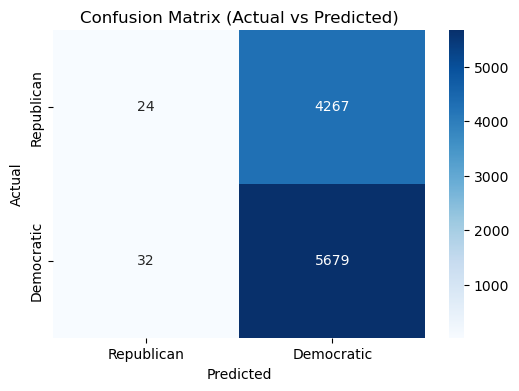

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(df_results, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Actual vs Predicted)")
plt.show()


### Reflections
The classifier overwhelmingly predicted tweets as Democratic, even when they were actually from Republican candidates. It correctly identified most Democratic tweets but failed almost entirely to recognize Republican ones. This suggests the model may be biased due to imbalanced training data or a lack of distinctive Republican features.